# Detecting individual trees from the LiDAR point cloud data
The primary task is to develop a pipeline for **detecting individual trees** from the LiDAR point
cloud data. The goal is to **identify the locations of tree tops** within the forest plots and compare
the detected trees with the ground truth field inventory data.

In [8]:
# necessary libraries
import geopandas as gpd
import laspy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
import seaborn as sns
import os
import math
import threading
import queue
import scipy
from scipy import stats
from scipy.spatial import ConvexHull, convex_hull_plot_2d

# 1. Preprocess the Data

## Load the LiDAR point cloud data and normalize it if needed.

In [9]:
data = os.getcwd()+"/data/"
with open(data+"field_survey.geojson") as f:
    field_survey = gpd.read_file(f)
field_survey.shape
field_survey.head()

,plot,tree_no,species,d1,d2,dbh,age,height,angle,comment,geometry
0,1.0,1.0,Birch,47.2,46.2,46.70,NaN,26.5,0.0,None,POINT (547075.84 6450425.243)
1,1.0,2.0,Aspen,27.9,29.1,28.50,NaN,NaN,0.0,None,POINT (547074.299 6450419.542)
2,1.0,3.0,Fir,12.1,13.0,12.55,NaN,NaN,0.0,None,POINT (547077.454 6450419.994)
3,1.0,4.0,Aspen,23.3,23.7,23.50,69.0,27.4,0.0,None,POINT (547078.211 6450419.02)
4,1.0,5.0,Aspen,23.2,31.3,27.25,NaN,NaN,0.0,None,POINT (547074.669 6450415.573)


In [10]:
height_described = field_survey["height"].dropna().describe()
min_height = height_described["min"]
max_height = height_described["max"]

print(max_height)

34.2


In [11]:
def check_is_aligned(xyplane,pval):  
    """based on the assumption that a plot that is not turned properly will not have a uniform spread of points along the x and y axes"""
    
    rows, columns = xyplane.shape
    rng = np.random.default_rng()
    px = stats.ks_2samp([x for x,y in xyplane],stats.uniform.rvs(size=rows, random_state=rng)).pvalue
    py = stats.ks_2samp([y for x,y in xyplane],stats.uniform.rvs(size=rows, random_state=rng)).pvalue
    p = min([px,py])
    return(p > pval)

def get_angle(x1,y1,x2,y2,x3,y3):
    """returns the angle between the line from (x1,y1) to (x2,y2) and the line from (x1,y1) to (x3,y3)"""

    a = [x3-x1,y3-y1]
    b = [x2-x1,y2-y1]
    la = math.sqrt(a[0]**2+a[1]**2)
    lb = math.sqrt(b[0]**2+b[1]**2)
    ab = a[0]*b[0]+a[1]*b[1]
    return(math.acos(ab/(la*lb)))

def lowest_4_indices(l):
    """l = list, returns the indices of the four lowest values"""

    lc = l.copy()
    v1 = min(lc)
    lc.remove(v1)
    v2 = min(lc)
    lc.remove(v2)
    v3 = min(lc)
    lc.remove(v3)
    v4 = min(lc)
    i1 = l.index(v1)
    i2 = l.index(v2)
    i3 = l.index(v3)
    i4 = l.index(v4)
    return([i1,i2,i3,i4])

def reorder(corners):
    """given four corners in a rectangle, reorders them to never have two successive points be diagonally opposed"""

    res = [corners[0]]                          #start with some corner
    l = len(corners)                            #to know how many corners we need to reorder
    corners = np.delete(corners,0,0)            #remove the first corner, so it is not found later on
    for i in range(1,l):
        KDT = scipy.spatial.KDTree(corners)
        ind = KDT.query(res[-1],k=1)[1]         #the closest remaining point to the last corner we found cannot be diagonally opposed to
        res += [corners[ind]]                   #the last corner
        corners = np.delete(corners,ind,0)      #remove the corner we found, to not obtain it again
    return(res)


def find_corners(xyplane):
    """xyplane = 2d numpy array
    supposes that this is a cloud in the shape of a diamond or rectangle, that is not aligned with the axes, and that has been
    normalised to [0,1]x[0,1]
    finds three of the corner points of this cloud, and angle in rad between the line between the first two corners, and the x-axis
    NOTE: this process supposes that the point cloud is sufficiently dense, and has no big outliers that could give a bad convex envelope,
    in the best case bad data will give a rough transformation, in the worst case the corners will be completely wrong"""
    
    #STEP 1: Find convex hull

    rng = np.random.default_rng()
    hull = ConvexHull(xyplane)                      
    hullpoints = np.asarray([[xyplane[x][0],xyplane[x][1]] for x in hull.vertices])     #points on the convex hull

    #--------------

    #STEP 2: Find all angles between points of the hull and their neighbours

    angles = []
    l = len(hullpoints)
    for i in range(l):
        xn,yn = hullpoints[(i+1)%l]
        xl,yl = hullpoints[(i-1)%l]
        x,y = hullpoints[i]
        angles += [get_angle(x,y,xl,yl,xn,yn)]

    #--------------

    #STEP 3: Find 4 points of the hull that have the lowest angle to their neighbours, as these are likely to be the corners

    indices = lowest_4_indices(angles)
    corners = reorder(hullpoints[indices])
    x1,y1 = corners[0]
    x2,y2 = corners[1]
    x3,y3 = corners[2]

    #--------------

    #Compute angle between the first two corners we found and the x axis

    d = math.sqrt((x2-x1)**2+(y2-y1)**2)
    alpha = math.acos((x2-x1)/d)

    #--------------

    return(x1,x2,x3,y1,y2,y3,alpha)

In [12]:
def rotate_point_2D(xc,yc,xp,yp,z,alpha):
    """xc,yc = coordinates of point to be rotated around
    xp,yp = coordinates of point to rotate
    alpha = angle in rad to rotate counter clockwise
    z = passthrough variable for ease of usage"""
    
    x = xc + math.cos(alpha) * (xp - xc) - math.sin(alpha) * (yp - yc)
    y = yc + math.sin(alpha) * (xp - xc) + math.cos(alpha) * (yp - yc)
    return [x,y,z]

def rotate_cloud(df,pval,x1,y1,alpha):
    """df = dataframe with columns x,y,z (not plot!)
    rotates all points by alpha rad counter clockwise around the point (x1,y1) in the xy plane, leaves the 
    z coordinates unchanged. Returns a normalised dataframe with named columns"""

    vals = df.to_numpy()                                                #store values in an array for easy iteration
    vals_rotated = [rotate_point_2D(x1,y1,x,y,z,alpha) for x,y,z in vals]      #apply rotation around corner (x1,y1) by -alpha rad
                                                                        #note that the rotation is carried out in the xy plane and the 
                                                                        #z coordinates are left unchanged
    df_rotated = pd.DataFrame(vals_rotated).rename(columns={0: "x", 1: "y", 2: "z"})    #create new dataframe with the rotated points
    df_rotated = (df_rotated-df_rotated.min())/(df_rotated.max()-df_rotated.min())      #renormalize dataframe
    return(df_rotated)

def translate_cloud(df,x1,y1,x2,y2):
    """df = dataframe with columns x,y,z (not plot!)
    translates all points by a variable amount on the xy plane to align the left side of the diamond with the y axis
    leaves the z axis unchanged
    returns a normalised dataframe with named columns"""

    vals = df.to_numpy()

    #STEP 1: Find equation of side of the diamond

    m = (y2-y1)/(x2-x1)                                                 #get equation of line between (x1,y1) and (x3,y3)
    p = y1 - m                                                          #where y = mx + p

    #--------------

    #STEP 2: Substract the x values obtained from the line equation, renormalise and rename columns for consistency

    vals_shifted = [(x-(y-p)/m,y,z)for x,y,z in vals]                   #shift values to get a rectangle
    df_shifted = pd.DataFrame(vals_shifted).rename(columns={0: "x", 1: "y", 2: "z"})    #create new dataframe with translated points
    df_shifted = (df_shifted-df_shifted.min())/(df_shifted.max()-df_shifted.min())      #renormalize dataframe

    #--------------

    return(df_shifted)
   
def normalise_cloud(df,i,pval=0.05,plot = False):
    """df = dataframe with columns x y and z (no column plot!)
        pval = p value to be used for kolmogorov smirnov test"""
    
    #STEP 1: NORMALISE TO [0,1]x[0,1]

    df = df.rename(columns={0: "x", 1: "y", 2: "z"})        #rename columns
    df = (df-df.min())/(df.max()-df.min())                  #linear normalisation to [0,1] of all coordinates
    xyplane = df.drop(columns = ["z"]).to_numpy()           #drop z axis as to normalise we use a "top down" view
    
    #--------------
    
    #Plotting

    if plot:
        fig, axs = plt.subplots(1,3)
        fig.set_figheight(5)
        fig.set_figwidth(15)

    #--------------

    #STEP 2: ROTATION TO ALIGN ONE SIDE OF CLOUD WITH AXIS

    #find three corners ((x1,y1) and (x3,y3) are diagonally opposed) and angle to rotate by

    x1,x2,x3,y1,y2,y3,alpha = find_corners(xyplane)         #find 3 of the 4 corners needed for rotation and translation

    #--------------

    #Plotting

    if plot:

        X = [p[0] for p in xyplane]
        Y = [p[1] for p in xyplane]
        axs[0].set_title("After normalising to [0,1]x[0,1]")
        axs[0].set_xlabel('x')
        axs[0].set_ylabel('y')
        axs[0].scatter(X,Y)
        axs[0].scatter([x1,x2,x3],[y1,y2,y3],marker = "X")

    #--------------

    #Rotation and normalisation

    xtest, ytest, filler = rotate_point_2D(x1,y1,x2,y2,0,alpha)     #compute rotation of one corner around other corner
    if (ytest < y1 + 0.05) and (ytest > y1 - 0.05):                 #if the two corners align by turning by alpha we turn 
        df_rotated = rotate_cloud(df,pval,x1,y1,alpha)              #the whole cloud by alpha
    else:
        xtest, ytest, filler = rotate_point_2D(x1,y1,x2,y2,0,-alpha)    #else we rotate by -alpha
        if (ytest < y1 + 0.05) and (ytest > y1 - 0.05):
            df_rotated = rotate_cloud(df,pval,x1,y1,-alpha)
        else:                                                       #serves as a failsafe
            df_rotated = df
    df_rotated = (df_rotated-df_rotated.min())/(df_rotated.max()-df_rotated.min())      #renormalise after rotation

    #--------------

    #Retrieve new rotated corners
    
    i1 = df.index[(df['x'] == x1) & (df['y'] == y1)].tolist()[0]        #get indexes of corners before transformations
    i2 = df.index[(df['x'] == x2) & (df['y'] == y2)].tolist()[0]        #to easily get their values after the transformations
    i3 = df.index[(df['x'] == x3) & (df['y'] == y3)].tolist()[0]

    x1,y1,z1 = df_rotated.iloc[i1].to_numpy()                           #retrieve rotated and normalised corners
    x2,y2,z2 = df_rotated.iloc[i2].to_numpy()
    x3,y3,z3 = df_rotated.iloc[i3].to_numpy()

    #Plotting

    if plot:
        vals_rotated = df_rotated.to_numpy()                            #get array of rotated values for ease of plotting
        X = [p[0] for p in vals_rotated]
        Y = [p[1] for p in vals_rotated]
        axs[1].set_title("After rotation")
        axs[1].set_xlabel('x')
        axs[1].scatter(X,Y)
        axs[1].scatter([x1,x2,x3],[y1,y2,y3],marker = "X")

    #--------------

    #STEP 3: TRANSLATION TO ALIGN OTHER SIDE OF CLOUD WITH AXIS

    #Translation

    df_shifted = translate_cloud(df_rotated,x2,y2,x3,y3)
    vals_shifted = df_shifted.to_numpy()

    #--------------

    #Plotting

    if plot:
        X = [p[0] for p in vals_shifted]
        Y = [p[1] for p in vals_shifted]
        axs[2].set_title("After translation")
        axs[2].set_xlabel('x')
        axs[2].scatter(X,Y)
        fig.suptitle("Normalisation for plot " + str(i))
        plt.show()

    #--------------

    return(df_shifted)

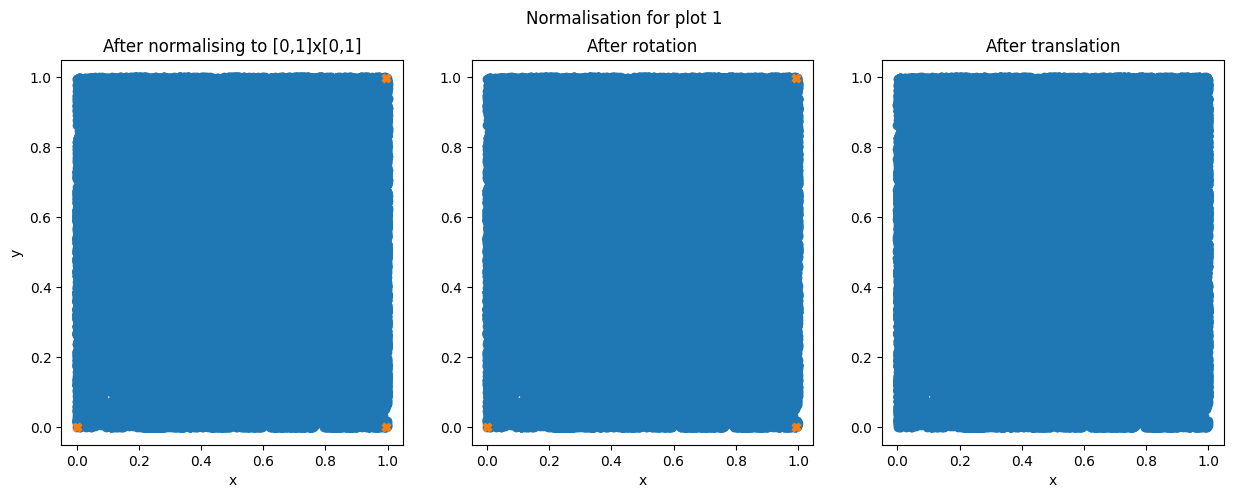

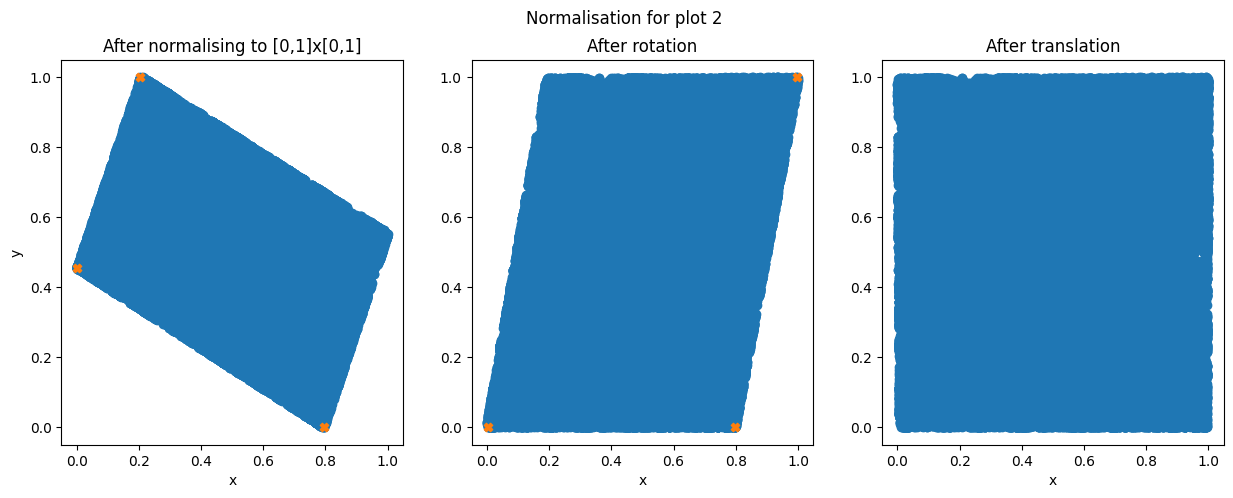

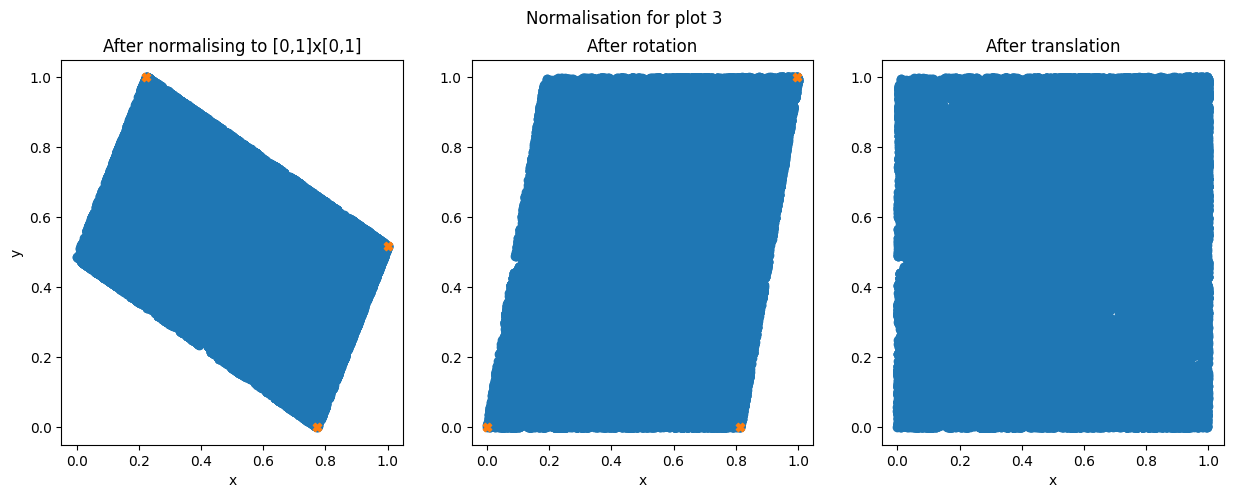

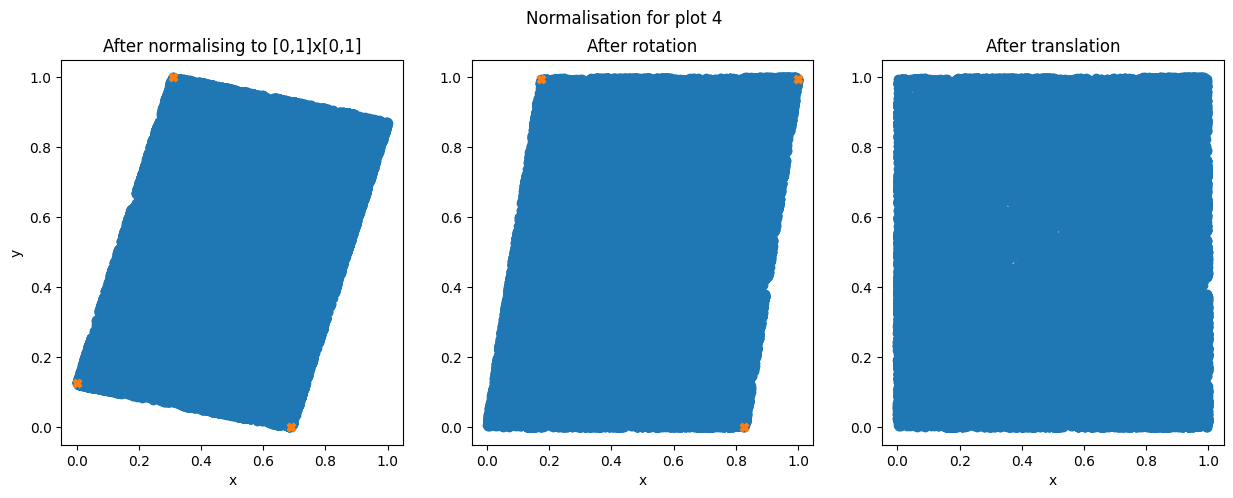

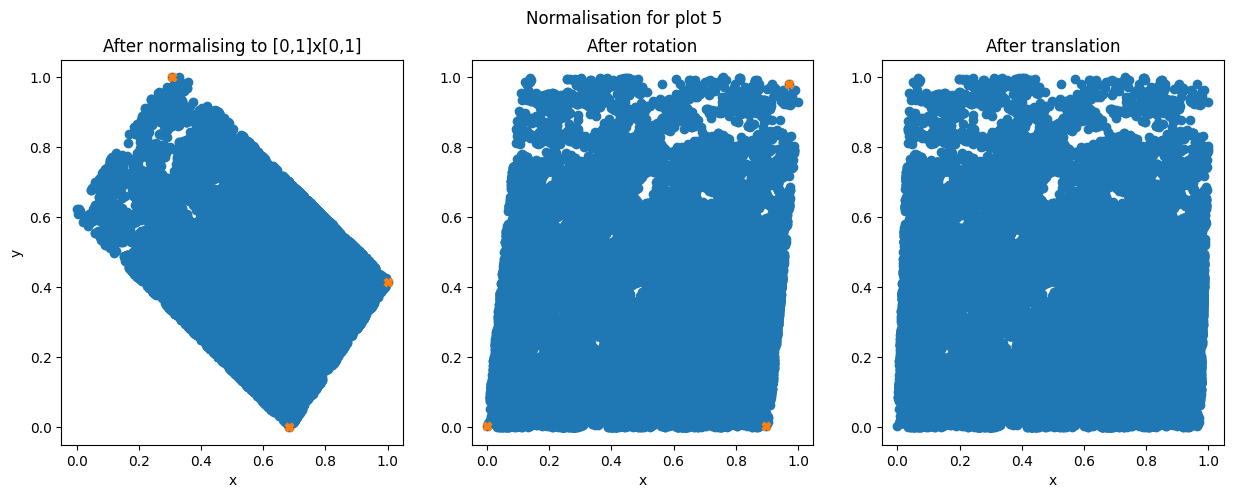

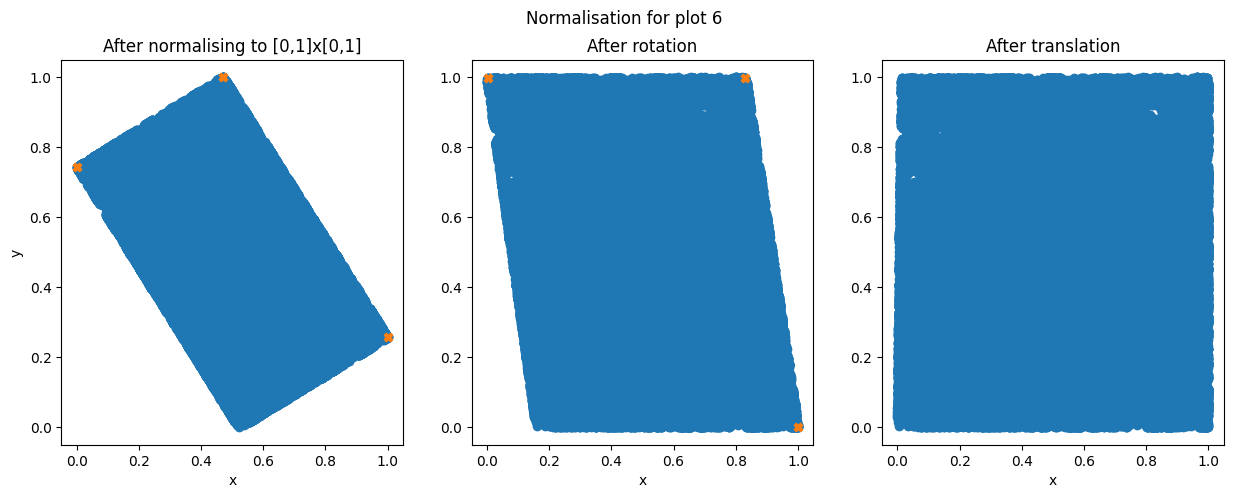

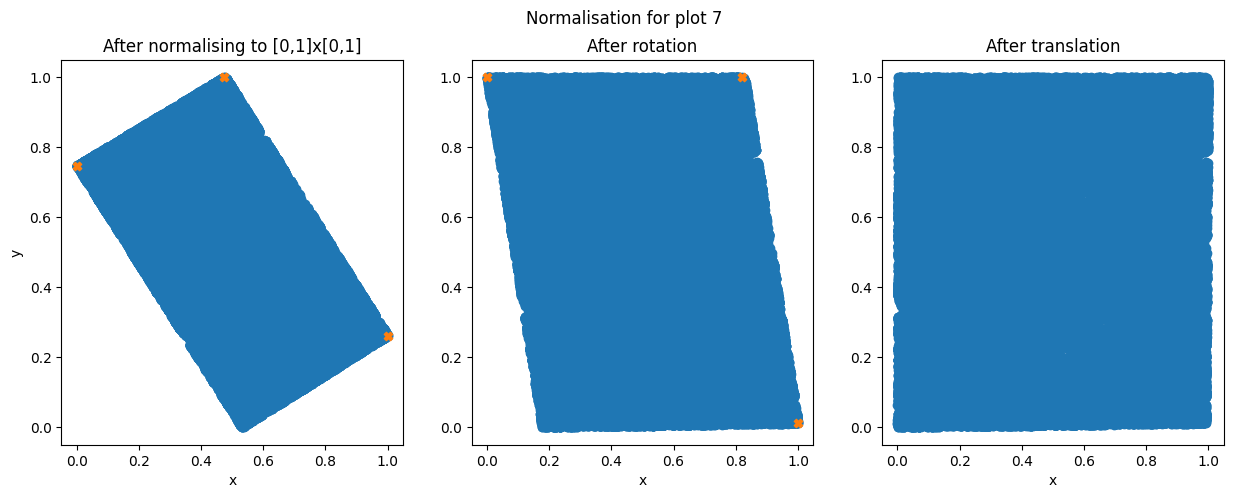

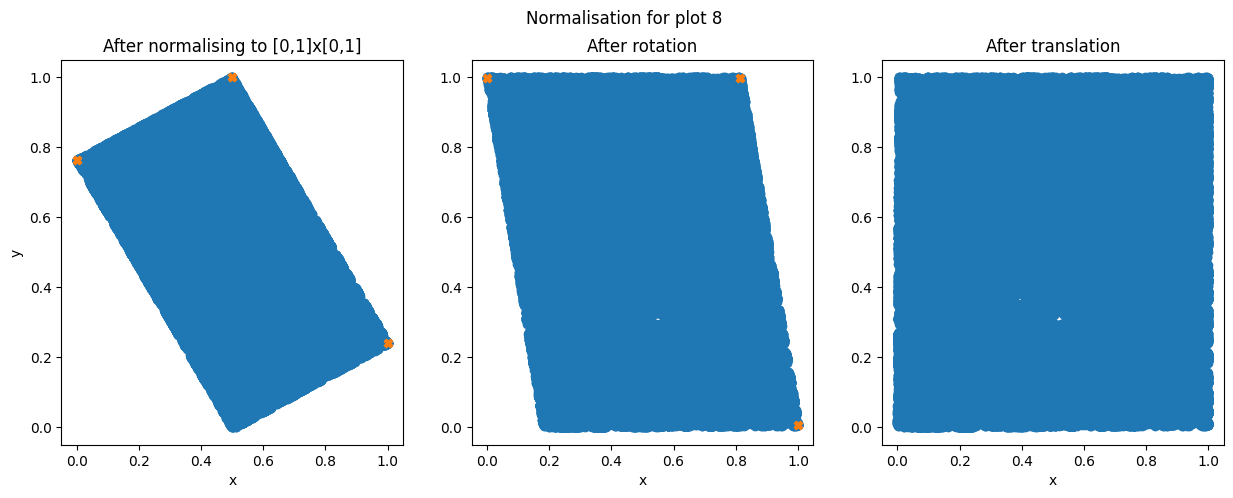

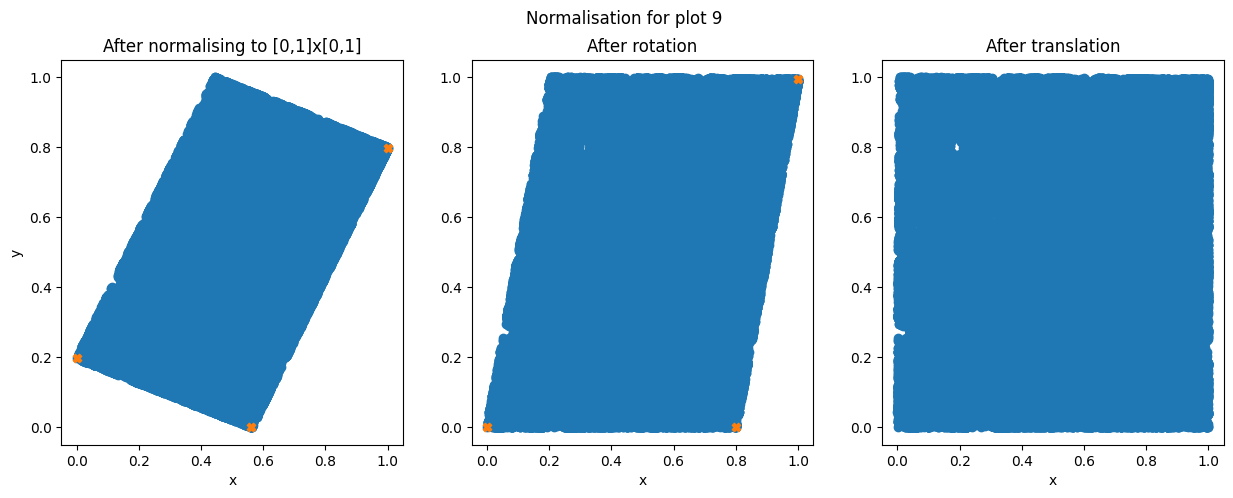

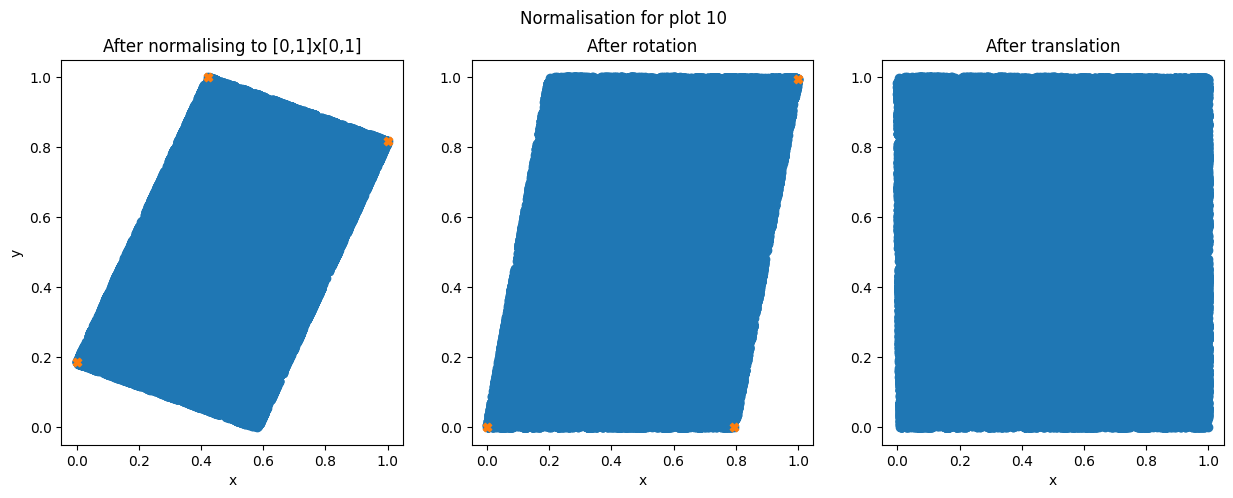

In [13]:
def load_lidar(indices,plot = False):
    """reads the .las files in succession, for each one normalises them into a square base, within 
    [0,1]x[0,1]x[0,1], puts all the (x,y,z) values into a dataframe, each with a number in the column plot
    corresponding to the file they were obtained from. The normalisation is done on a plot per plot basis.
    If plot = True, plots the normalisation process from a top down perspective"""

    for i in indices:
        temp = laspy.read(data+"/als/plot_"+ "0"*(2-len(str(i))) + str(i) + ".las").xyz     #reads file as numpy array
        tempdf = pd.DataFrame(temp)                                     #converts numpy array to dataframe
        tempdf = normalise_cloud(tempdf,i,plot = plot)
        tempdf["plot"] = i                                              #add column to store which file these points come from
        if i == 1:
            lidardf = tempdf.copy()
        else:
            lidardf = pd.concat([lidardf,tempdf],ignore_index= True).copy()
    return(lidardf)

lidardf = load_lidar([i for i in range(1,11)],plot = True)

Take a look at our point clouds

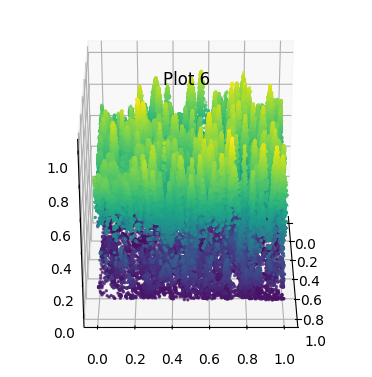

In [14]:
def plot_3d_cloud(df,i):
    #plot1 = laspy.read(data+"/als/plot_"+ "0"*(2-len(str(i))) + str(i) + ".las").xyz
    plot = df.loc[df["plot"] == i]
    plot = plot.drop(columns=['plot']).to_numpy()
    plot -= plot.min(axis=0, keepdims=True)

    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(1, 2, 1, projection="3d")

    ax.scatter(
        *plot.swapaxes(0, 1),
        c=plot[:, 2],
        s=2,
    )

    ax.view_init(elev=30, azim=0)

    ax.set_title("Plot " + str (i), y=0.83)

    ax.set_aspect("equal")

plot_3d_cloud(lidardf,6)

## Filter irrelevant points (e.g., ground points below a height threshold) and remove residual noise.

In [16]:
def num_neigh(df,r):
    """df = dataframe cotaining the columns x y z and plot, for only one plot
    returns array containing the number of neighbours within radius r of all points"""
    KDT = scipy.spatial.KDTree(np.asarray(df.drop(columns=['plot'])))        #compute KDTree for fast computation
    arr = df.drop(columns=['plot']).to_numpy()                               #create array of (x,y,z) for iteration
    return([KDT.query_ball_point(point,r,workers = -1,return_length = True) for point in arr])

def dist_filter(df,r,a):
    """df = dataframe containing the columns x y z and plot, for all plots
    returns dataframe, where the points where the number of neighbours within radius r lie in the lower a quantile of the 
    number of neighbours are excluded"""
    iter = 0                                        #for iterative creation of dataframe
    for i in df["plot"].unique():                   #iterate through plots
        df_i = df.loc[df["plot"] == i]              #extract selected plot
        df_i["num_neigh"] = num_neigh(df_i,r)       #add column containing for each row the corresponding number of neighbours within r
        min_neigh = df_i.quantile(a)["num_neigh"]   #get quantile for number of neighbours
        df_i = df_i.loc[df_i["num_neigh"] >= min_neigh].drop(columns =["num_neigh"])
                                                    #drop every row with too few neighbours
        if iter == 0:                               #build dataframe iteratively
            res = df_i
            iter += 1
        else:
            res = pd.concat([res,df_i],ignore_index= True)
    return(res)

def load_and_filter(a1,a2,r1,r2):
    """ a1 = specifies which quantile to use to filter out lower points
        a2 = specifies which quantile to use to filter out points with few neighbours
        r1 = radius to check for neighbours for first filtering
        r2 = radius to check for neighbours for second filtering
        
        Returns dataframe where lower a1 quantile of points are filtered out (plot per plot), and
        applies two succesive radius based filters (plot per plot)"""

    df = load_lidar([i for i in range(1,11)],plot = False)

    #Filter out lower a quantile, where the quantiles are computed plot per plot
    #Otherwise, if the ground level is not the same for each plot we remove
    #inequally between the different plots

    for i in df["plot"].unique():
        zQ = df.loc[df["plot"] == i].quantile(a1)["z"]               #compute height quantile of plot
        df = df.loc[-((df["z"] < zQ) & (df["plot"] == i))]      #remove low points from selected plot

    #--------------

    #Distance based filtering using KDTrees

    df = dist_filter(dist_filter(df,r1,a2),r2,a2)               #apply two filters successively, one rougher one finer

    #--------------

    return(df)

lidardf = load_and_filter(a1 = 0.1, a2 = 0.05,r1 = 0.1,r2 =0.01)

C:\Users\yanis\AppData\Local\Temp\ipykernel_16600\801405019.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_i["num_neigh"] = num_neigh(df_i,r)       #add column containing for each row the corresponding number of neighbours within r
C:\Users\yanis\AppData\Local\Temp\ipykernel_16600\801405019.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_i["num_neigh"] = num_neigh(df_i,r)       #add column containing for each row the corresponding number of neighbours within r
C:\Users\yanis\AppData\Local\T

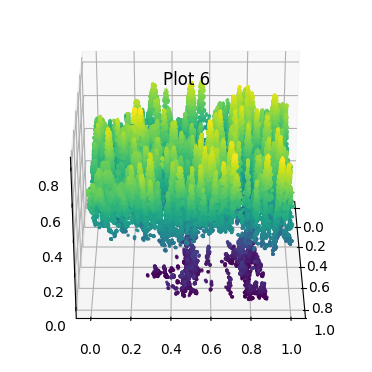

In [18]:
plot_3d_cloud(lidardf,6)

In [19]:
lidardf

,x,y,z,plot
0,0.969919,0.006524,0.837884,1
1,0.961937,0.000690,0.831124,1
2,0.995803,0.075791,0.774657,1
3,0.980824,0.064078,0.743422,1
4,0.979102,0.066104,0.665074,1
...,...,...,...,...
2245530,0.296411,0.997407,0.429271,10
2245531,0.261273,0.997755,0.421381,10
2245532,0.237419,0.998012,0.450818,10
2245533,0.227406,0.997593,0.416336,10


In [20]:
field_survey

,plot,tree_no,species,d1,d2,dbh,age,height,angle,comment,geometry
0,1.0,1.0,Birch,47.2,46.2,46.70,NaN,26.5,0.0,None,POINT (547075.84 6450425.243)
1,1.0,2.0,Aspen,27.9,29.1,28.50,NaN,NaN,0.0,None,POINT (547074.299 6450419.542)
2,1.0,3.0,Fir,12.1,13.0,12.55,NaN,NaN,0.0,None,POINT (547077.454 6450419.994)
3,1.0,4.0,Aspen,23.3,23.7,23.50,69.0,27.4,0.0,None,POINT (547078.211 6450419.02)
4,1.0,5.0,Aspen,23.2,31.3,27.25,NaN,NaN,0.0,None,POINT (547074.669 6450415.573)
...,...,...,...,...,...,...,...,...,...,...,...
3597,10.0,522.0,Fir,10.0,9.3,9.65,NaN,NaN,0.0,None,POINT (546598.563 6449083.925)
3598,10.0,523.0,Tilia,19.6,21.0,20.30,NaN,NaN,0.0,Two tops,POINT (546594.681 6449079.402)
3599,10.0,524.0,Fir,22.8,24.7,23.75,NaN,NaN,0.0,None,POINT (546576.237 6449102.09)
3600,10.0,525.0,Birch,23.3,23.1,23.20,NaN,NaN,0.0,None,POINT (546600.707 6449170.22)


## Partition the dataset into training and testing sets.

Our goal is it to **identify the locations of tree tops** within the forest plots and compare
the detected trees with the ground truth field inventory data.
Therefore we combine  both datasets "lidardf" and "field_survey" to one dataframe which has 5 rows:
1. x (float)
2. y (float)
3. z (float)
4. plot (int [1-10])
5. treetop ([True/False])

Of course we don't have the variable treetop yet so we need to compare geometry of the field survey data with the x and y axis of our points. We should be able to find all. 


In [21]:
# try to look for a way to check for 
field_survey['geometry']

0        POINT (547075.84 6450425.243)
1       POINT (547074.299 6450419.542)
2       POINT (547077.454 6450419.994)
3        POINT (547078.211 6450419.02)
4       POINT (547074.669 6450415.573)
                     ...              
3597    POINT (546598.563 6449083.925)
3598    POINT (546594.681 6449079.402)
3599     POINT (546576.237 6449102.09)
3600     POINT (546600.707 6449170.22)
3601    POINT (546602.318 6449170.102)
Name: geometry, Length: 3602, dtype: geometry

In [22]:
print("what is a geometry objject? ")
print(field_survey['geometry'][0].__doc__)

what is a geometry objject? 

    A geometry type that represents a single coordinate with
    x,y and possibly z values.

    A point is a zero-dimensional feature and has zero length and zero area.

    Parameters
    ----------
    args : float, or sequence of floats
        The coordinates can either be passed as a single parameter, or as
        individual float values using multiple parameters:

        1) 1 parameter: a sequence or array-like of with 2 or 3 values.
        2) 2 or 3 parameters (float): x, y, and possibly z.

    Attributes
    ----------
    x, y, z : float
        Coordinate values

    Examples
    --------
    Constructing the Point using separate parameters for x and y:

    >>> p = Point(1.0, -1.0)

    Constructing the Point using a list of x, y coordinates:

    >>> p = Point([1.0, -1.0])
    >>> print(p)
    POINT (1 -1)
    >>> p.y
    -1.0
    >>> p.x
    1.0
    


In [23]:

x = field_survey['geometry'][0].x
y = field_survey['geometry'][0].y
print(field_survey['geometry'][0])
print(x)

POINT (547075.839999999 6450425.24299999)
547075.839999999
